In [123]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns



In [125]:
customers=pd.read_csv('/Users/nihaalnadaf/Downloads/Customers.csv')
transactions=pd.read_csv('/Users/nihaalnadaf/Downloads/Transactions.csv')

In [127]:
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending by customer
    'Quantity': 'mean',  # Average quantity purchased
    'Price': 'mean'  # Average product price
}).reset_index()

In [129]:
transaction_summary

,CustomerID,TotalValue,Quantity,Price
0,C0001,3354.52,2.400000,278.334000
1,C0002,1862.74,2.500000,208.920000
2,C0003,2725.38,3.500000,195.707500
3,C0004,5354.88,2.875000,240.636250
4,C0005,2034.24,2.333333,291.603333
...,...,...,...,...
194,C0196,4982.88,3.000000,416.992500
195,C0197,1928.65,3.000000,227.056667
196,C0198,931.83,1.500000,239.705000
197,C0199,1979.28,2.250000,250.610000


In [131]:
# Merge the data
customer_features = customers.merge(transaction_summary, on="CustomerID", how="left")

In [133]:
customer_features.head(5)

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,2.400000,278.334000
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,2.500000,208.920000
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,3.500000,195.707500
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,2.875000,240.636250
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,2.333333,291.603333


In [135]:
customer_features.isnull().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
TotalValue      1
Quantity        1
Price           1
dtype: int64

In [137]:
numerical_features=['TotalValue','Quantity','Price']
customer_features[numerical_features]=customer_features[numerical_features].fillna(0)

In [139]:
customer_features.isnull().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
TotalValue      0
Quantity        0
Price           0
dtype: int64

In [141]:
# one hot encoding for region feature
categorical_columns = ['Region']
encoder = OneHotEncoder(sparse_output=False)  # drop_first to avoid dummy variable trap
encoded_columns = encoder.fit_transform(customer_features[categorical_columns])

In [143]:
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))
customer_features = pd.concat([customer_features.drop(columns=categorical_columns), encoded_df], axis=1)


In [145]:
customer_features.head(5)

,CustomerID,CustomerName,SignupDate,TotalValue,Quantity,Price,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,3354.52,2.400000,278.334000,0.0,0.0,0.0,1.0
1,C0002,Elizabeth Lutz,2022-02-13,1862.74,2.500000,208.920000,1.0,0.0,0.0,0.0
2,C0003,Michael Rivera,2024-03-07,2725.38,3.500000,195.707500,0.0,0.0,0.0,1.0
3,C0004,Kathleen Rodriguez,2022-10-09,5354.88,2.875000,240.636250,0.0,0.0,0.0,1.0
4,C0005,Laura Weber,2022-08-15,2034.24,2.333333,291.603333,1.0,0.0,0.0,0.0


In [147]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            200 non-null    object 
 1   CustomerName          200 non-null    object 
 2   SignupDate            200 non-null    object 
 3   TotalValue            200 non-null    float64
 4   Quantity              200 non-null    float64
 5   Price                 200 non-null    float64
 6   Region_Asia           200 non-null    float64
 7   Region_Europe         200 non-null    float64
 8   Region_North America  200 non-null    float64
 9   Region_South America  200 non-null    float64
dtypes: float64(7), object(3)
memory usage: 15.8+ KB


In [149]:
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'], errors='coerce')
min_signup_date = customer_features['SignupDate'].min()

In [151]:
# Create a new feature: days since the earliest signup
customer_features['days_since_signup'] = (customer_features['SignupDate'] - min_signup_date).dt.days
customer_features = customer_features.drop(columns=['SignupDate'], axis=1)

In [153]:
customer_features.head(2)

,CustomerID,CustomerName,TotalValue,Quantity,Price,Region_Asia,Region_Europe,Region_North America,Region_South America,days_since_signup
0,C0001,Lawrence Carroll,3354.52,2.4,278.334,0.0,0.0,0.0,1.0,169
1,C0002,Elizabeth Lutz,1862.74,2.5,208.920,1.0,0.0,0.0,0.0,22


In [155]:
correlation_matrix = customer_features[['days_since_signup', 'Quantity']].corr()

In [157]:
correlation_matrix

,days_since_signup,Quantity
days_since_signup,1.000000,0.043108
Quantity,0.043108,1.000000


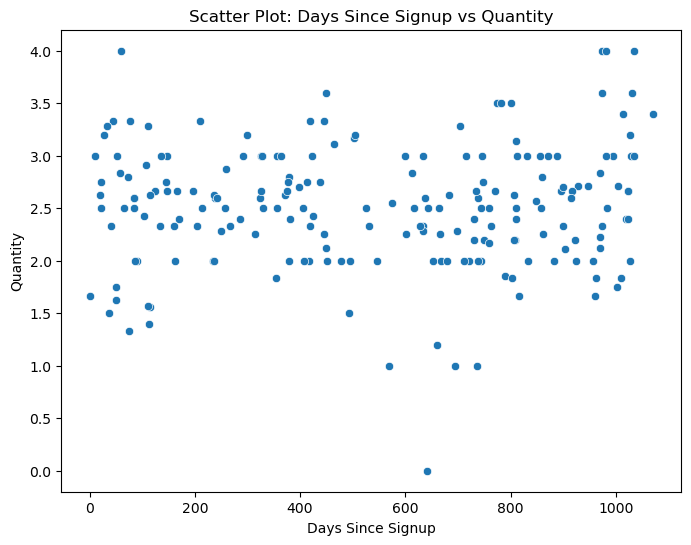

In [159]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='days_since_signup', y='Quantity', data=customer_features)
plt.title('Scatter Plot: Days Since Signup vs Quantity')
plt.xlabel('Days Since Signup')
plt.ylabel('Quantity')
plt.show()

**There is no relation at all between quantity and signup date (neither linear nor non-linear)**

In [162]:
customer_features=customer_features.drop(columns='days_since_signup')

In [164]:
scaler = StandardScaler()
columns_to_drop = ['CustomerID', 'CustomerName'] 
scaled_features = scaler.fit_transform(customer_features.drop(columns=columns_to_drop, axis=1))

In [166]:
customer_features.head(2)

,CustomerID,CustomerName,TotalValue,Quantity,Price,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,3354.52,2.4,278.334,0.0,0.0,0.0,1.0
1,C0002,Elizabeth Lutz,1862.74,2.5,208.920,1.0,0.0,0.0,0.0


In [168]:
# Determine the optimal number of clusters using the Elbow Method (KMeans)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


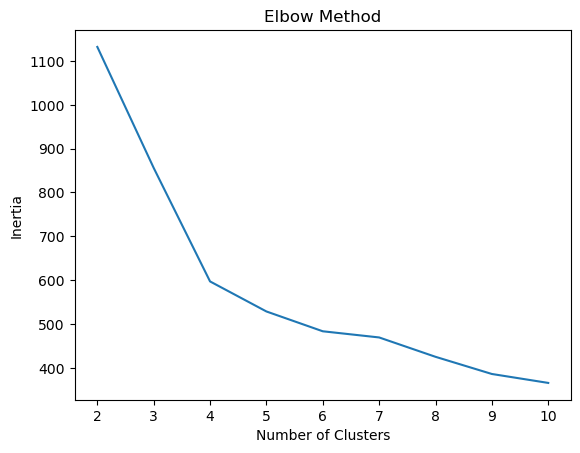

In [170]:
plt.plot(range(2, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [172]:
# Based on the elbow plot 
optimal_clusters = 4


###  KMeans clustering

In [175]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

In [177]:
customer_features.head(2)

,CustomerID,CustomerName,TotalValue,Quantity,Price,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,Lawrence Carroll,3354.52,2.4,278.334,0.0,0.0,0.0,1.0,2
1,C0002,Elizabeth Lutz,1862.74,2.5,208.920,1.0,0.0,0.0,0.0,3


In [179]:
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
sil_score = silhouette_score(scaled_features, customer_features['Cluster'])
ch_score = calinski_harabasz_score(scaled_features, customer_features['Cluster'])

In [181]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")
print(f"Calinski-Harabasz Index: {ch_score}")

DB Index: 0.9391808091523912
Silhouette Score: 0.4520950217786072
Calinski-Harabasz Index: 87.85519509521238


In [183]:
# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
customer_features['PCA1'] = principal_components[:, 0]
customer_features['PCA2'] = principal_components[:, 1]

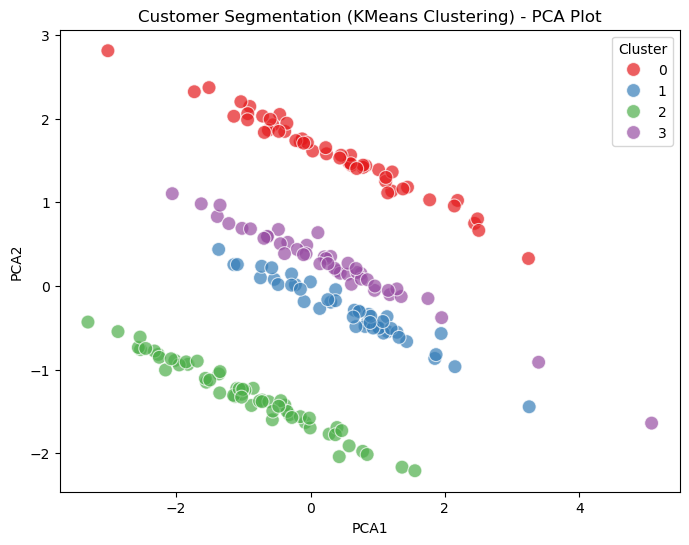

In [185]:
# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='Set1', s=100, alpha=0.7)
plt.title("Customer Segmentation (KMeans Clustering) - PCA Plot")
plt.show()